In [1]:
import feature_e
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
import mlflow
import mlflow.sklearn


In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
print("Tracking URI:", mlflow.tracking.get_tracking_uri())

Tracking URI: http://localhost:5000


In [3]:
features = feature_e.run_future_eng()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 22s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 28s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 17s


In [4]:
features = features.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

In [5]:
features

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
mlflow.set_tracking_uri("http://localhost:5000")
print("Tracking URI:", mlflow.tracking.get_tracking_uri())

Tracking URI: http://localhost:5000


In [7]:
features_train = features[features["TARGET"].notnull()]
features_test = features[features["TARGET"].isnull()]

In [8]:
train_labels = features_train['TARGET']

In [9]:
train = features_train.drop("TARGET", axis=1)
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [10]:
train.drop(["index", "SK_ID_CURR"], axis=1, inplace=True)

In [11]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(train)

SimpleImputer(strategy='median')

In [12]:
train = imp.transform(train)

In [13]:
experiment_name = "model_log"
try:
    exp_id = mlflow.create_experiment(name=experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

In [14]:
ften_score = make_scorer(fbeta_score, beta=0.1)

In [15]:
grid = GridSearchCV(LogisticRegression(), param_grid={"C":[0,1.0]}, scoring=ften_score)

In [16]:
grid.fit(train, train_labels)

GridSearchCV(estimator=LogisticRegression(), param_grid={'C': [0, 1.0]},
             scoring=make_scorer(fbeta_score, beta=0.1))

In [17]:
grid.best_params_

{'C': 1.0}

In [18]:
with mlflow.start_run(experiment_id=exp_id, run_name="run_1"):
    C =grid.best_params_["C"]
    mlflow.log_param("C",C)
    log_reg =LogisticRegression( C=C )
    log_reg.fit(train, train_labels)
    model_info = mlflow.sklearn.log_model(sk_model=log_reg, artifact_path="model")

In [19]:
features_test.drop(["index", "SK_ID_CURR", "TARGET"], axis=1, inplace=True)

In [20]:
features_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [21]:
test = imp.transform(features_test)

In [22]:
log_reg_pred = log_reg.predict(test)

In [23]:
log_reg_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
np.count_nonzero(log_reg_pred == 1)

332

In [25]:
experiment_name2 = "random_forest"
try:
    exp_id = mlflow.create_experiment(name=experiment_name2)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name2).experiment_id

In [26]:
ften_score = make_scorer(fbeta_score, beta=0.1)

In [27]:
grid = GridSearchCV(RandomForestClassifier(random_state =50, verbose =1 , n_jobs = -1), param_grid={"n_estimators":[150,180]}, scoring=ften_score)

In [28]:
grid.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=50,
                                              verbose=1),
             param_grid={'n_estimators': [150, 180]},
             scoring=make_scorer(fbeta_score, beta=0.1))

In [29]:
grid.best_params_

{'n_estimators': 150}

In [30]:
mlflow.set_tracking_uri("http://localhost:5000")

In [31]:
with mlflow.start_run(experiment_id=exp_id, run_name="run_2"):
    n_estimators = grid.best_params_["n_estimators"]
    random_state = 150
    verbose = 1
    n_jobs = -1
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("verbose", verbose)
    mlflow.log_param("n_jobs", n_jobs)
    random_forest = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, verbose=verbose, n_jobs=n_jobs)
    random_forest.fit(train, train_labels)
    mlflow.sklearn.autolog()
# mlflow.sklearn.log_model(sk_model=random_forest, artifact_path="random_forest")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


In [32]:
features = list(features_train.columns)

In [35]:
feature_importance_values =random_forest.feature_importances_

In [36]:
len(features), len(feature_importance_values)

(798, 795)

In [37]:
feature_importances = pd.DataFrame({'feature': features[3:], 'importance': feature_importance_values})

In [38]:
features

['index',
 'SK_ID_CURR',
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMEN

In [39]:
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.5s finished


In [40]:
predict = random_forest.predict(test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.5s finished


In [41]:
predict

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
predict.max()

0.0

In [43]:
np.count_nonzero(predict == 1)

0

In [44]:
predictions

array([0.10666667, 0.09333333, 0.00666667, ..., 0.06666667, 0.06666667,
       0.22666667])

In [45]:
predictions.max()

0.48

In [46]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Random Forest (avg over folds)')
    plt.tight_layout()
    plt.savefig('RF_importances01.png')

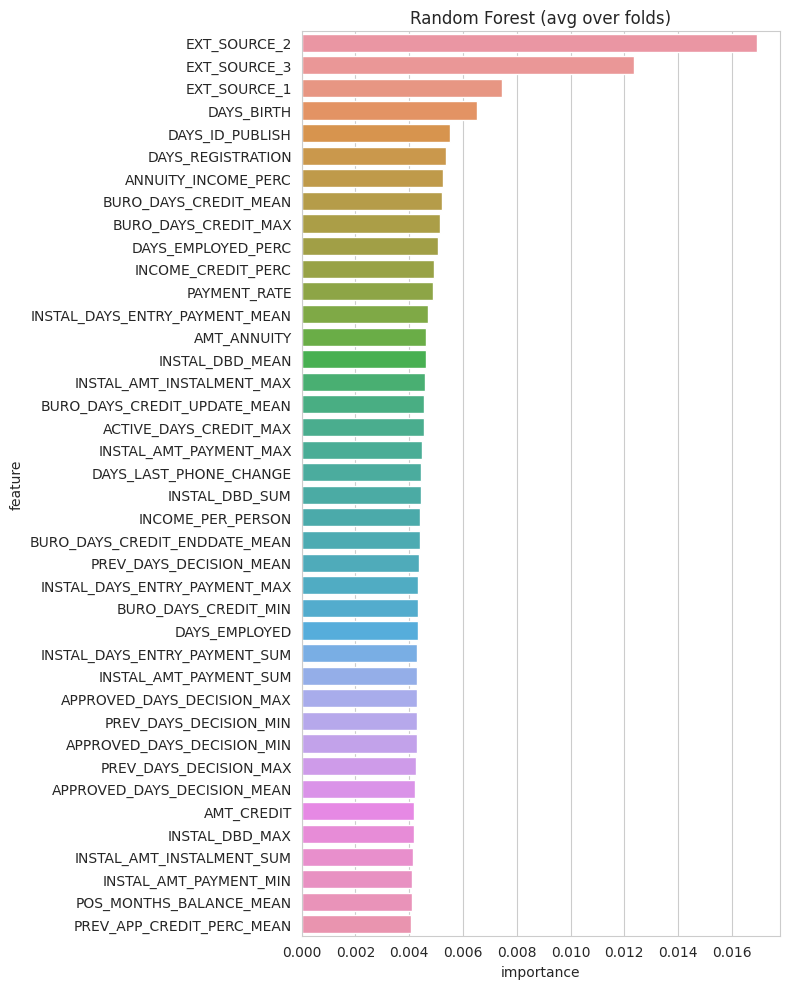

In [47]:
display_importances(feature_importances)